In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [2]:
import sys


import itertools
import numpy as np
import pandas as pd
from scipy import sparse
from scipy import ndimage

import matplotlib.pyplot as plt

import networkx as nx


from src.depth import DepthPoset, ShallowPair
from src import poset_scores

from tqdm import tqdm

# Load Image

/tmp/ipykernel_6495/766850352.py:3: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  image = ndimage.zoom(image, (0.5, 0.5, 1), order=1, grid_mode=True)


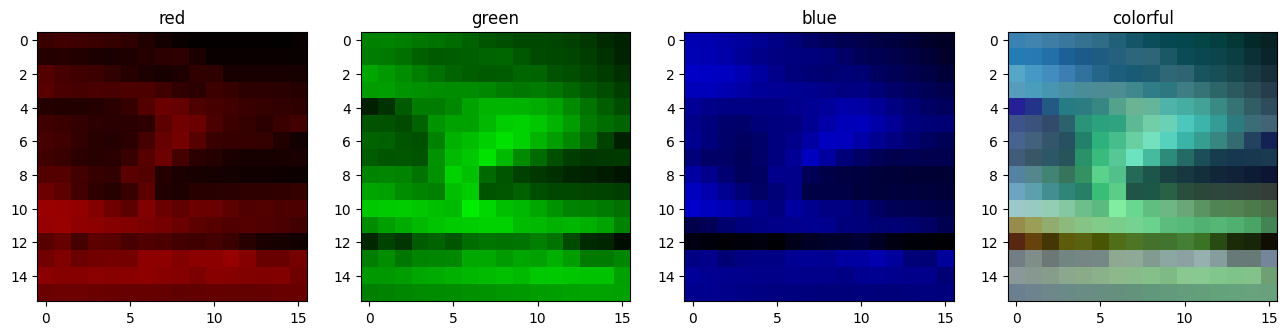

In [3]:
path = 'source/aurora.png'
image = plt.imread(path)[:, :, :3]
image = ndimage.zoom(image, (0.5, 0.5, 1), order=1, grid_mode=True)



fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for i, color in enumerate(['red', 'green', 'blue']):
    axs[i].set_title(color)
    image_to_show = np.zeros(image.shape)
    image_to_show[:, :, i] = image[:, :, i]
    axs[i].imshow(image_to_show)

#axs[3].set_title('black-white')
#axs[3].imshow(image.mean(axis=2).reshape([image.shape[0], image.shape[1], 1]) * np.ones([1, 1, 3]))

axs[3].set_title('colorful')
axs[3].imshow(image)

plt.show()

# Get border matrix from image

In [4]:
def get_unsorted_order(n, m, with_dims=True):
    """
    """
    # define order
    edges0 = [((x, y), (x+1, y)) for x, y in itertools.product(range(n - 1), range(m))]
    edges1 = [((x, y), (x, y+1)) for x, y in itertools.product(range(n), range(m - 1))]
    squares = list(itertools.product(range(n), range(m)))
    order = squares + edges0 + edges1

    if not with_dims:
        return order

    # define dimensions
    dims = np.concatenate([np.zeros(n*m, dtype=int), np.ones(2*n*m - n - m, dtype=int)])
    assert len(dims) == len(order)

    return order, dims

In [5]:
def get_order_filtrations(img):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    edges0_filtration = np.concatenate(np.max([img[1:, :], img[:-1, :]], axis=0))
    edges1_filtration = np.concatenate(np.max([img[:, 1:], img[:, :-1]], axis=0))
    squares_filtration = np.concatenate(img)

    filtration = np.concatenate([squares_filtration, edges0_filtration, edges1_filtration, ])
    return filtration

In [6]:
def get_sorted_order(img, with_dims=True, with_filtration=True):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    order, dims = get_unsorted_order(img.shape[0], img.shape[1])
    filtration = get_order_filtrations(img)

    indices = np.lexsort((dims, filtration))
    order = [order[i] for i in indices]
    dims = dims[indices]
    filtration = filtration[indices]
    if with_filtration and with_dims:
        return order, dims, filtration
    if with_dims:
        return order, dims
    if with_filtration:
        return order, filtration
    return order

In [7]:
def diagonal_overlay(n, m):
    rows, cols, data = [], [], []

    for i in range(n):
        # Диагональ слева направо (↘)
        if i < m:
            rows.append(i)
            cols.append(i)
            data.append(True)

        # Диагональ справа налево (↘)
        if i < m:
            rows.append(n - i - 1)
            cols.append(m - i - 1)
            data.append(True)

    return sparse.csr_matrix((data, (rows, cols)), shape=(n, m), dtype=bool)


In [8]:

def transpose_minor_diagonal(bm: sparse.csr_matrix) ->sparse. csr_matrix:
    if bm.shape[0] != bm.shape[1]:
        raise ValueError("Matrix must be square to transpose along the minor diagonal.")
    
    n = bm.shape[0]
    bm_coo = bm.tocoo()
    
    # Меняем местами строки и столбцы, с отражением относительно последнего индекса
    new_row = n - 1 - bm_coo.col
    new_col = n - 1 - bm_coo.row
    
    # Создаём новую матрицу
    return sparse.coo_matrix((bm_coo.data, (new_row, new_col)), shape=(n, n)).tocsr()

In [9]:
def get_unsorted_border_matrix(n, m):
    """
    """
    # edges0
    matrix_e0 = diagonal_overlay(n*m - 1, n*m)
    mask = np.array([i % m != (m - 1) for i in range(matrix_e0.shape[0])])
    matrix_e0 = matrix_e0[mask]

    # edges1
    matrix_e1 = diagonal_overlay(m*(n-1), n*m)
    
    # dimension 1-2 submatrix
    bm = sparse.vstack([matrix_e0, matrix_e1])
    
    # geting full matrix
    N = 3*n*m - n - m
    bm = sparse.vstack([bm, sparse.csr_matrix((N - bm.shape[0], bm.shape[1]))])
    bm = sparse.hstack([sparse.csr_matrix((N, N - bm.shape[1])), bm])

    # transpose over minor diagonal
    bm = transpose_minor_diagonal(bm)
    
    return bm.astype(bool)

In [10]:
def get_sorted_border_matrix(img):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    n, m = img.shape
    bm = get_unsorted_border_matrix(n, m)

    order, dims = get_unsorted_order(img.shape[0], img.shape[1])
    filtration = get_order_filtrations(img)
    indices = np.lexsort((dims, filtration))

    bm = bm[indices, :]
    bm = bm[:, indices]
    
    return bm

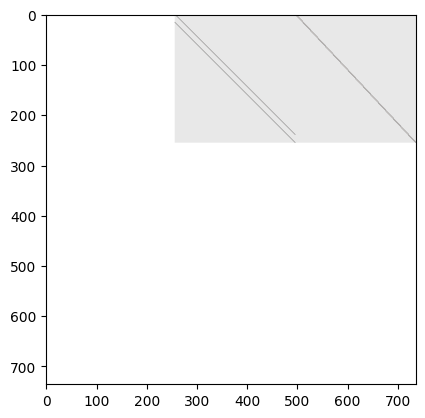

In [11]:
order, dims = get_unsorted_order(image.shape[0], image.shape[1])
bm = get_unsorted_border_matrix(image.shape[0], image.shape[1])

if len(dims) < 4096:
    matrix_dim_condition = dims.reshape((-1, 1)) == dims.reshape((1, -1)) - 1
    plt.imshow(matrix_dim_condition, cmap='Greys', vmin=0, vmax=6)

    bm_to_show = bm.toarray().astype(float)
    bm_to_show[bm_to_show == 0] = np.nan
    plt.imshow(bm_to_show, cmap='Reds')



# Simplifying Class

## Pixels to Disk

Here we are building the map 
$$
    f: D^2\subset \mathbb{R}^2 \to D^2
$$
such that
$$
    f: \delta D^2 \to (\cos\phi, \sin\phi), \phi\in[0, 2\pi)
$$

$n$ ordered points $p_1, ..., p_n \in \delta D^2$:
$$
    f(p_i) = (\cos(i\frac{2\pi}{n}), \sin(i\frac{2\pi}{n}))
$$
and for 1 point $p_c\in D^2/\delta D^2$
$$
    f(p_c) = (0, 0)
$$

We will need this to represent cell as a disk, and calculate height there, based on heights in the $n$ cell vertices

In [12]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def pixel_graph_laplacian(mask):
    """
    Строит дискретный лапласиан по 4-связной решётке на пикселях из mask.
    Возвращает:
    - L: разреженная матрица Лапласиана
    - pixel_to_index: отображение (i,j) -> индекс строки
    - index_to_pixel: обратное отображение
    """
    h, w = mask.shape
    pixel_to_index = {}
    index_to_pixel = {}
    idx = 0
    for i in range(h):
        for j in range(w):
            if mask[i, j]:
                pixel_to_index[(i, j)] = idx
                index_to_pixel[idx] = (i, j)
                idx += 1

    N = len(pixel_to_index)
    L = lil_matrix((N, N))
    for (i, j), k in pixel_to_index.items():
        neighbors = [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        deg = 0
        for ni, nj in neighbors:
            if (ni, nj) in pixel_to_index:
                L[k, pixel_to_index[(ni,nj)]] = -1
                deg += 1
        L[k, k] = deg
    return L.tocsr(), pixel_to_index, index_to_pixel

def solve_harmonic(mask, boundary_values):
    """
    Решает уравнение Лапласа внутри маски с граничными условиями.
    boundary_values: dict (i,j) -> значение на границе.
    """
    L, p2i, i2p = pixel_graph_laplacian(mask)
    N = len(p2i)

    b = np.zeros(N)
    fixed = np.zeros(N, dtype=bool)
    x_fixed = np.zeros(N)

    for (i, j), value in boundary_values.items():
        k = p2i[(i,j)]
        fixed[k] = True
        x_fixed[k] = value

    free = ~fixed
    L_free = L[free][:, free]
    b_free = -L[free][:, fixed] @ x_fixed[fixed]

    x = np.zeros(N)
    x[fixed] = x_fixed[fixed]
    x[free] = spsolve(L_free, b_free)

    result = {}
    for k in range(N):
        result[i2p[k]] = x[k]
    return result


def compute_parametrization(mask, boundary_phi, center_pixel, boundary_phi_extension=None):
    """
    mask: 2D np.array of 0/1
    boundary_phi: dict {(i,j): phi in radians}
    center_pixel: (i,j)
    Returns: dict (i,j) -> (r, phi)
    """
    h, w = mask.shape

    # Solve r: 0 in center, 1 on boundary
    boundary_r = {p: 1.0 for p in boundary_phi}
    boundary_r[center_pixel] = 0.0
    r_map = solve_harmonic(mask, boundary_r)

    # Solve phi: fixed on boundary, harmonic inside
    boundary_phi_extended = dict()
    boundary_phi_extended.update(boundary_phi)
    if boundary_phi_extension is not None:
        boundary_phi_extended.update(boundary_phi_extension)
    phi_map_sin = solve_harmonic(mask, {key: np.sin(value) for key, value in boundary_phi_extended.items()})
    phi_map_cos = solve_harmonic(mask, {key: np.cos(value) for key, value in boundary_phi_extended.items()})
    phi_map = {p: np.atan2(phi_map_sin[p], phi_map_cos[p]) % (2*np.pi) for p in phi_map_cos.keys()}

    return {p: (r_map[p], phi_map[p]) for p in r_map}

In [13]:
from skimage import measure
import numpy as np
import matplotlib.pyplot as plt

def extract_ordered_boundary(mask):
    """
    Извлекает упорядоченную границу (в виде списка (i,j)) из бинарной маски.
    Возвращает:
        - список координат (float) вдоль границы, замкнутую ломаную
        - можно интерполировать в целочисленные координаты, если нужно
    """
    contours = measure.find_contours(mask.astype(float), level=0.5)
    if not contours:
        raise ValueError("Граница не найдена")
    
    # Если несколько контуров, берём самый длинный
    contour = max(contours, key=len)

    # Переводим из (y, x) в (i, j) и округляем при необходимости
    ordered_boundary = [(int(round(y)), int(round(x))) for y, x in contour]
    ordered_boundary = [(y, x) for y, x in contour]
    ordered_boundary = []
    for y, x, in contour:
        if y%1 == 0:
            y, x = int(y), int(x)
            if not mask[y, x]:
                x += 1
        else:
            y, x = int(y), int(x)
            if not mask[y, x]:
                y += 1
        if (y, x) not in ordered_boundary:
            ordered_boundary.append((y, x))
    

    return ordered_boundary


In [14]:
def get_closest_point_of_border(border: dict, center: tuple, with_value: bool=True):
    """
    """
    closest = next(border.keys().__iter__())
    closest_distance = np.linalg.norm([closest[i] - center[i] for i in range(2)])
    for point in border.keys():
        point_distance = np.linalg.norm([point[i] - center[i] for i in range(2)])
        if point_distance < closest_distance:
            closest = point
            closest_distance = point_distance
    if with_value:
        closest_value = border[closest]
        return closest, closest_value
    return closest

def bresenham_line(point0, point1):
    """
    """
    x0, y0 = point0
    x1, y1 = point1
    points = []
    
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    
    return points


In [15]:
def define_boundary_phi_extension(center_pixel, boundary_phi):
    """
    """
    closest_pixel0, closest_value0 = get_closest_point_of_border(boundary_phi, center_pixel, with_value=True)

    line0 = bresenham_line(closest_pixel0, center_pixel)
    line1 = []
    if closest_pixel0 != center_pixel:
        vector = np.array(closest_pixel0) - np.array(center_pixel)
        print(vector)
        cond = lambda key: np.dot(np.array(key) - np.array(center_pixel), vector) <= 0
        cuted_boundary_phi = {key: value for key, value in boundary_phi.items() if cond(key)}
        closest_pixel1, closest_value1 = get_closest_point_of_border(cuted_boundary_phi, center_pixel, with_value=True)
        line1 = bresenham_line(closest_pixel1, center_pixel)

    boundary_phi_extension = dict()
    for pixel in line1:
        boundary_phi_extension.update({pixel: closest_value1})
    for pixel in line0:
        boundary_phi_extension.update({pixel: closest_value0})
    

    return boundary_phi_extension

In [16]:
def split_boundary_phi(center_pixel, boundary_phi, n=3, angle0=None):
    """
    Split boundary_phi to n parts
    """
    if angle0 is None:
        closest_pixel, closest_value = get_closest_point_of_border(boundary_phi, center_pixel, with_value=True)
        angle0 = np.atan2(*(np.array(closest_pixel)  - np.array(center_pixel)))
        angle0 -= np.pi/n
        angle0 %= 2*np.pi
    
    cx, cy = center_pixel
    parts = [{} for _ in range(n)]

    for (x, y), val in boundary_phi.items():
        dx = x - cx
        dy = y - cy
        angle = np.arctan2(dy, dx) - angle0
        angle = (angle + 2 * np.pi) % (2 * np.pi)  # Приводим к [0, 2π)
        sector = int(n * angle / (2 * np.pi)) % n
        parts[sector][(x, y)] = val

    return parts

def define_boundary_phi_extension(center_pixel, boundary_phi, n=3, angle0=None):
    """
    """
    boundary_parts = split_boundary_phi(center_pixel, boundary_phi, n=n, angle0=angle0)
    lines = []
    values = []
    for boundary_part in boundary_parts:
        closest_pixel, closest_value = get_closest_point_of_border(boundary_part, center_pixel, with_value=True)
        lines.append(bresenham_line(closest_pixel, center_pixel))
        values.append(closest_value)

    boundary_phi_extension = dict()    
    for line, value in zip(lines, values):
        for pixel in line:
            boundary_phi_extension.update({pixel: value})
    boundary_phi_extension.pop(center_pixel, None)
    return boundary_phi_extension

        

In [17]:
def orientation_is_counter_clockwise(boundary_phi):
    """
    Parameters:
    -----------
    boundary_phi: dict
        Keys are tuples - coordiates of border pixels
        Values - are angle values in these pixels

    Returns:
    --------
    clockwise: bool
        True, if border is clockwise
    """
    s_boundary_phi = pd.Series(boundary_phi)
    s_boundary_phi = s_boundary_phi.sort_values()
    
    coords = s_boundary_phi.index.to_list()
    if coords[0] != coords[-1]:
        coords.append(coords[0])
    
    x, y = np.transpose(coords)
    area = (x[:-1]*y[1:] - x[1:]*y[:-1]).sum()
    counter_clockwise = area < 0
    return counter_clockwise
    


In [18]:
def get_phi_arround_center(center_pixel, boundary_phi):
    """
    """
    closest_pixel, closest_value = get_closest_point_of_border(boundary_phi, center_pixel, with_value=True)
    adding_value = np.atan2(*(np.array(closest_pixel) - np.array(center_pixel))) - closest_value

    counter_clockwise = orientation_is_counter_clockwise(boundary_phi)
    phi = np.pi*np.arange(0, 2, 0.25)
    xs = center_pixel[0] + np.cos(phi).round().astype(int)
    ys = center_pixel[1] + np.sin(phi).round().astype(int)
    values = (adding_value + phi*(-1)**counter_clockwise)%(2*np.pi)
    phi_arround_center = {(x, y): value for x, y, value in zip(xs, ys, values)}
    return phi_arround_center

In [19]:
def compute_radial_parametrization(mask, boundary_phi, center_pixel, excepted_mean=0.8):
    """
    """
    # Solve r: 0 in center, 1 on boundary
    boundary_r = {p: 1.0 for p in boundary_phi}
    boundary_r[center_pixel] = 0.0
    r_map = solve_harmonic(mask, boundary_r)
    if not excepted_mean is None:
        mean_value = np.mean(list(r_map.values()))
        d = np.log(excepted_mean)/np.log(mean_value)
        r_map = {key: value**d for key, value in r_map.items()}
    return r_map

In [20]:
def angle_mean(angles):
    """
    Усреднение углов через комплексные числа: e^{iθ}
    """
    sin_sum = np.sum(np.sin(angles))
    cos_sum = np.sum(np.cos(angles))
    return np.arctan2(sin_sum, cos_sum)

def solve_harmonic_angle(mask, boundary_values, max_iter=1000, tol=1e-5):
    """
    Решает дискретное уравнение Лапласа в маске, где значения — углы (модуль 2π).
    boundary_values: dict (i,j) -> значение угла (в радианах, [0, 2π) или размотанные)
    """
    h, w = mask.shape
    u = np.zeros((h, w), dtype=float)
    fixed = np.zeros((h, w), dtype=bool)

    # Инициализация значений
    for (i, j), value in boundary_values.items():
        u[i, j] = value
        fixed[i, j] = True

    # Для остальных случайные значения (можно и нули)
    u[mask & ~fixed] = 0.0

    for it in range(max_iter):
        max_change = 0.0
        u_new = u.copy()

        for i in range(1, h - 1):
            for j in range(1, w - 1):
                if not mask[i, j] or fixed[i, j]:
                    continue

                neighbors = []
                for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]:
                    if mask[ni, nj]:
                        neighbors.append(u[ni, nj])

                if neighbors:
                    avg = angle_mean(neighbors)
                    delta = np.abs(np.arctan2(np.sin(u[i,j] - avg), np.cos(u[i,j] - avg)))
                    max_change = max(max_change, delta)
                    u_new[i, j] = avg

        u = u_new
        if max_change < tol:
            break

    # Возвращаем только значения внутри маски
    result = {(i, j): u[i, j] for i in range(h) for j in range(w) if mask[i, j]}
    return result

In [21]:
def compute_parametric_angle(r_map, boundary0, boundary1):
    """
    """
    res = dict()
    for point, radius in r_map.items():
        closest0, value0 = get_closest_point_of_border(boundary0, point, with_value=True)
        closest1, value1 = get_closest_point_of_border(boundary1, point, with_value=True)
        value = (1 - radius)*value0 + radius*value1
        res.update({point: value})
    return res
        

In [22]:
def compute_disk_parametrization(mask, boundary_phi, center_pixel, excepted_mean=0.6):
    """
    mask: 2D np.array of 0/1
    boundary_phi: dict {(i,j): phi in radians}
    center_pixel: (i,j)
    Returns: dict (i,j) -> (r, phi)
    """
    r_map = compute_radial_parametrization(mask, boundary_phi, center_pixel, excepted_mean=excepted_mean)

    # Solve phi: fixed on boundary, harmonic inside
    boundary_phi_center = get_phi_arround_center(center_pixel, boundary_phi)
    boundary_phi_extended = dict()
    boundary_phi_extended.update(boundary_phi_center)
    boundary_phi_extended.update(boundary_phi)
    mask_punctured = mask.copy()
    mask_punctured[center_pixel[0], center_pixel[1]] = 0

    for x, y in list(boundary_phi_extended.keys()):
        if mask_punctured[x, y] == 0:
             boundary_phi_extended.pop((x, y))

    phi_map_sin = solve_harmonic(mask_punctured, {key: np.sin(value) for key, value in boundary_phi_extended.items()})
    phi_map_cos = solve_harmonic(mask_punctured, {key: np.cos(value) for key, value in boundary_phi_extended.items()})
    #boundary_phi_sin = {key: np.sin(value) for key, value in boundary_phi.items()}
    #boundary_phi_cos = {key: np.cos(value) for key, value in boundary_phi.items()}
    #boundary_phi_center_sin = {key: np.sin(value) for key, value in boundary_phi_center.items()}
    #boundary_phi_center_cos = {key: np.cos(value) for key, value in boundary_phi_center.items()}
    
    #phi_map_sin = compute_parametric_angle(r_map, boundary_phi_sin, boundary_phi_center_sin)
    #phi_map_cos = compute_parametric_angle(r_map, boundary_phi_cos, boundary_phi_center_cos)

    phi_map = {p: np.atan2(phi_map_sin[p], phi_map_cos[p]) % (2*np.pi) for p in phi_map_cos.keys()}
    
    #phi_map = solve_harmonic_angle(mask_punctured, boundary_values=boundary_phi_extended, max_iter=100, tol=1e-5)
    phi_map = {key: value%(2*np.pi) for key, value in phi_map.items()}

    phi_map.update({center_pixel: 0})
    return {p: (r_map[p], phi_map[p]) for p in r_map}

<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:34: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_6495/780801497.py:34: SyntaxWarning: invalid escape sequence '\p'
  sc = axs[0].scatter(boundary_x, boundary_y, marker='o', label='Boundary $\phi$',
/tmp/ipykernel_6495/780801497.py:12: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  mask = ndimage.zoom(mask, (12, 15), order=1, grid_mode=True).astype(bool).astype(int)


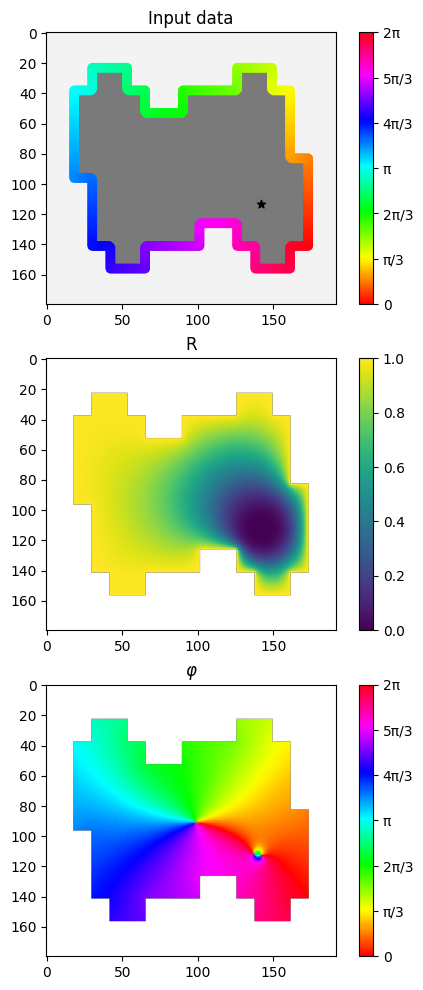

In [61]:
# define mask
mask = np.zeros([16, 12])
mask[2, 3:6] = 1
mask[3, 2:9] = 1
mask[4, 3:10] = 1
mask[5:8, 8] = 1
mask[5:11, 4:8] = 1
mask[8:11, 3] = 1
mask[11, 2:9] = 1
mask[12, 3:10] = 1
mask[13, 6:9] = 1
mask = ndimage.zoom(mask, (12, 15), order=1, grid_mode=True).astype(bool).astype(int)

# define center
center_x, center_y = 4, 7
center_x, center_y = np.argwhere(mask)[np.random.choice(np.arange(mask.sum(), dtype=int))]

# get the boundary
boundary = extract_ordered_boundary(mask)
boundary_x, boundary_y = np.transpose(boundary) 
boundary_angles = np.linspace(0, 2*np.pi, len(boundary))

# plot input
fig, axs = plt.subplots(3, figsize=(6, 12))
#
axs[0].set_title('Input data')
axs[0].imshow(mask.transpose(), cmap='Greys', vmin=-0.2, vmax=1.8, zorder=0)

axs[0].scatter(center_x, center_y, color='black', marker='*', label='Center', zorder=3)

axs[0].plot(boundary_x, boundary_y, color='white', linestyle='-')
axs[0].plot(boundary_x, boundary_y, color='black', linestyle=':', label='Border')

sc = axs[0].scatter(boundary_x, boundary_y, marker='o', label='Boundary $\phi$',
                    c=boundary_angles, cmap='hsv', norm=plt.Normalize(0, 2 * np.pi), zorder=2)
cbar = plt.colorbar(sc, ax=axs[0])
radian_ticks = np.linspace(0, 2*np.pi, 7)
radian_labels = [0, "π/3", "2π/3", "π", "4π/3", "5π/3", "2π"]
cbar.set_ticks(radian_ticks)
cbar.set_ticklabels(radian_labels)




# compute parametrization
center_pixel = center_x, center_y
boundary_phi = {pos: phi for pos, phi in zip(boundary, boundary_angles)}

#boundary_phi_extension = define_boundary_phi_extension(center_pixel, boundary_phi, n=6, angle0=6)

#parametrization = compute_parametrization(mask, boundary_phi, center_pixel, boundary_phi_extension=boundary_phi_extension)
parametrization = compute_disk_parametrization(mask, boundary_phi, center_pixel)


# plotresults
img_radius = np.nan*mask
img_phi = np.nan*mask

for (x, y), (r, phi) in parametrization.items():
    img_radius[x, y] = r
    img_phi[x, y] = phi
    
# 
axs[1].set_title('R')
im1 = axs[1].imshow(img_radius.transpose(), cmap='viridis')
cbar = plt.colorbar(im1, ax=axs[1])

axs[2].set_title(r'$\varphi$')
im2 = axs[2].imshow(img_phi.transpose(), cmap='hsv')
cbar = plt.colorbar(im2, ax=axs[2])
cbar.set_ticks(radian_ticks)
cbar.set_ticklabels(radian_labels)

plt.show()

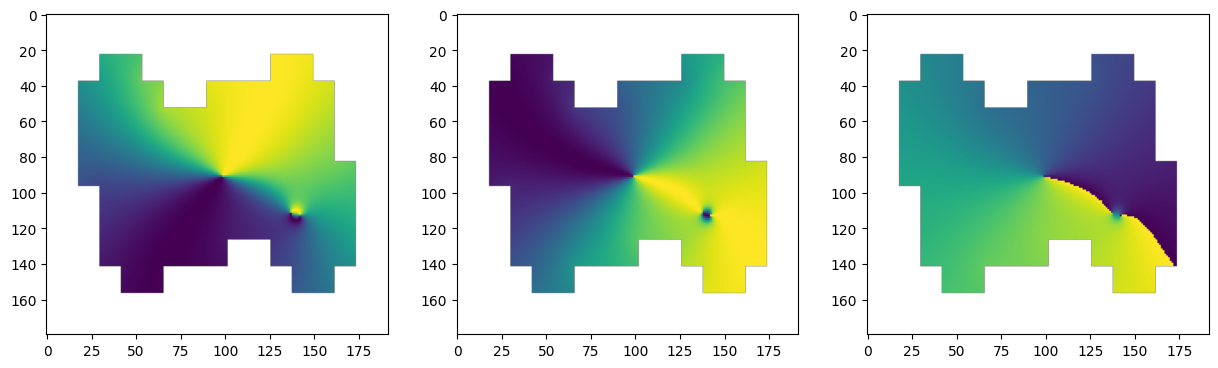

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

axs[0].imshow(np.transpose(np.sin(img_phi)))
axs[1].imshow(np.transpose(np.cos(img_phi)))
axs[2].imshow(np.transpose(img_phi))

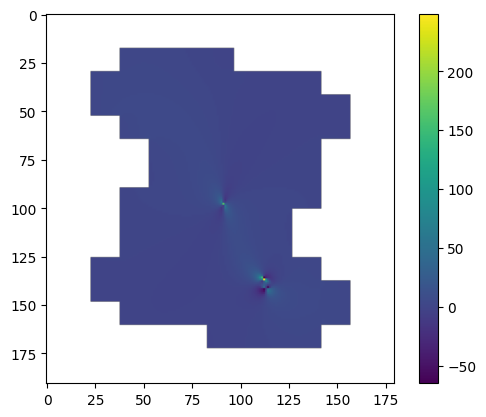

In [63]:
img_phi_sin_diff_y = (np.sin(img_phi)[1:] - np.sin(img_phi)[:-1])*img_phi.shape[0]
sm = plt.imshow(img_phi_sin_diff_y)
plt.colorbar()

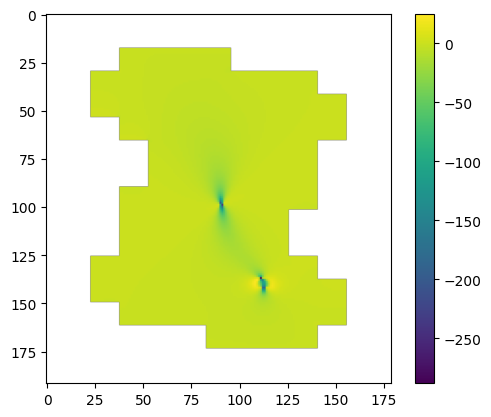

In [64]:
img_phi_sin_diff_y = (np.sin(img_phi)[:, 1:] - np.sin(img_phi)[:, :-1])*img_phi.shape[1]
sm = plt.imshow(img_phi_sin_diff_y)
plt.colorbar()

In [93]:
# define mask
mask = np.zeros([16, 12])
mask[2, 3:6] = 1
mask[3, 2:9] = 1
mask[4, 3:10] = 1
mask[5:8, 8] = 1
mask[5:11, 4:8] = 1
mask[8:11, 3] = 1
mask[11, 2:9] = 1
mask[12, 3:10] = 1
mask[13, 6:9] = 1
mask = ndimage.zoom(mask, (4, 4), order=1, grid_mode=True).astype(bool).astype(int)

# define center
center_x, center_y = 4, 7
center_x, center_y = np.argwhere(mask)[np.random.choice(np.arange(mask.sum(), dtype=int))]

boundary_x, boundary_y = np.transpose(np.array(extract_ordered_boundary(mask)))
boundary_phi = np.linspace(0, 2*np.pi, len(boundary_x))
boundary_val = np.exp(1j*boundary_phi)



/tmp/ipykernel_6495/253169401.py:12: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  mask = ndimage.zoom(mask, (4, 4), order=1, grid_mode=True).astype(bool).astype(int)


In [101]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def solve_complex_laplace(mask, boundary_x, boundary_y, boundary_values, center):
    h, w = mask.shape
    idx_map = -np.ones((h, w), dtype=int)
    
    # Пронумеруем все внутренние точки маски
    interior_points = np.argwhere(mask)
    for idx, (i, j) in enumerate(interior_points):
        idx_map[i, j] = idx
    n = len(interior_points)

    A = lil_matrix((n, n), dtype=complex)
    b = np.zeros(n, dtype=complex)

    boundary_dict = {(x, y): val for x, y, val in zip(boundary_x, boundary_y, boundary_values)}
    center_idx = idx_map[center]

    for idx, (i, j) in enumerate(interior_points):
        if (i, j) == center:
            # Центр — зафиксированное значение
            A[idx, idx] = 1
            b[idx] = 0
            continue

        # Уравнение Лапласа
        A[idx, idx] = -4
        for ni, nj in [(i+1,j), (i-1,j), (i,j+1), (i,j-1)]:
            if not (0 <= ni < h and 0 <= nj < w):
                continue
            if mask[ni, nj]:
                A[idx, idx_map[ni, nj]] = 1
            elif (ni, nj) in boundary_dict:
                b[idx] -= boundary_dict[(ni, nj)]

    # Решаем
    u = spsolve(A.tocsr(), b)

    # Собираем финальную матрицу
    result = np.full(mask.shape, np.nan, dtype=complex)
    for (i, j), val in zip(interior_points, u):
        result[i, j] = val
    for (x, y), val in boundary_dict.items():
        result[x, y] = val
    result[center] = 0

    return result


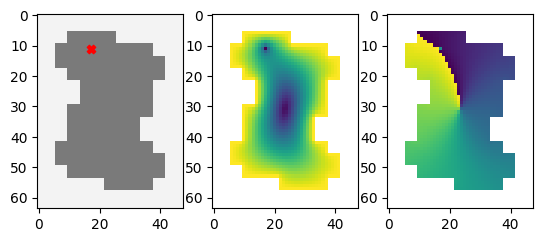

In [102]:
mask_unbordered = mask.copy().astype(bool)
mask_unbordered[boundary_x, boundary_y] = False
solution = solve_complex_laplace(mask_unbordered, boundary_x, boundary_y, boundary_val, (center_x, center_y))

fig, axs = plt.subplots(1, 3)
axs[0].imshow(mask, cmap='Greys', vmin=-0.2, vmax=1.8)
axs[0].scatter(center_y, center_x, color='red', marker='X')
axs[1].imshow(np.abs(solution))
axs[2].imshow(np.angle(solution))


In [103]:
import numpy as np
from scipy.interpolate import RBFInterpolator
from matplotlib.path import Path
import matplotlib.pyplot as plt

def compute_function_in_domain(boundary_z, boundary_val, z0, grid_res=300):
    """
    Приближает функцию f(z) = (z - z0) * exp(g(z)), аналитическую в области,
    с граничными значениями f(z) = boundary_val на boundary_z.
    
    Параметры:
    - boundary_z: массив комплексных точек на границе области
    - boundary_val: массив значений функции на границе, |val| = 1
    - z0: комплексное число — ноль функции внутри области
    - grid_res: разрешение сетки
    
    Возвращает:
    - Z: комплексная сетка (X + iY)
    - fZ: значения f(z) в точках сетки (с nan вне области)
    - mask: булева маска, указывающая, какие точки внутри области
    """
    # 1. Вычисляем g(z) на границе: g = log(f(z)/(z - z0))
    g_boundary = np.log(boundary_val / (boundary_z - z0))

    # 2. Задаём прямоугольную сетку, охватывающую границу
    x = np.linspace(np.real(boundary_z).min(), np.real(boundary_z).max(), grid_res)
    y = np.linspace(np.imag(boundary_z).min(), np.imag(boundary_z).max(), grid_res)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y

    # 3. Определяем, какие точки попадают внутрь границы
    boundary_xy = np.column_stack([np.real(boundary_z), np.imag(boundary_z)])
    path = Path(boundary_xy)
    points = np.column_stack([X.ravel(), Y.ravel()])
    mask = path.contains_points(points).reshape(X.shape)

    # 4. Интерполируем real и imag части g(z) отдельно
    coords = np.column_stack([np.real(boundary_z), np.imag(boundary_z)])
    g_real = np.real(g_boundary)
    g_imag = np.imag(g_boundary)

    rbf_real = RBFInterpolator(coords, g_real, neighbors=10)
    rbf_imag = RBFInterpolator(coords, g_imag, neighbors=10)

    interp_points = np.column_stack([X[mask], Y[mask]])
    gZ_real = rbf_real(interp_points)
    gZ_imag = rbf_imag(interp_points)
    gZ = gZ_real + 1j * gZ_imag

    # 5. Вычисляем f(z) = (z - z0) * exp(g(z))
    Z_inside = Z[mask]
    fZ_inside = (Z_inside - z0) * np.exp(gZ)

    # 6. Собираем в итоговый массив
    fZ = np.full_like(Z, np.nan, dtype=np.complex128)
    fZ[mask] = fZ_inside

    return Z, fZ, mask


In [121]:
def plot_f_magnitude(Z, fZ, mask, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.contourf(np.real(Z), np.imag(Z), np.abs(fZ), levels=100, cmap='viridis')
    

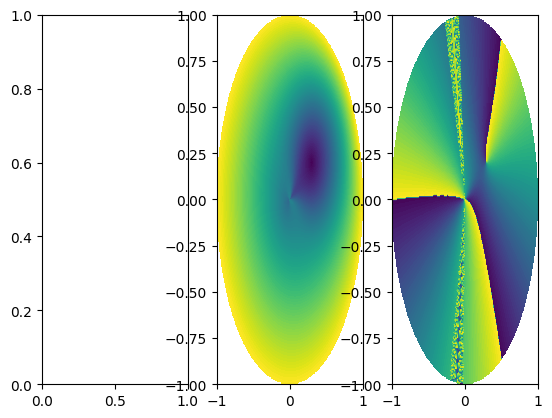

In [125]:
# Пример: окружность
theta = np.linspace(0, 2*np.pi, 300, endpoint=False)
boundary_z = np.exp(1j * theta)  # единичная окружность
boundary_val = np.exp(1j * 3 * theta)  # функция степени 3
z0 = 0.3 + 0.2j  # внутри окружности

Z, fZ, mask = compute_function_in_domain(boundary_z, boundary_val, z0)

fig, axs = plt.subplots(1, 3)

axs[1].contourf(np.real(Z), np.imag(Z), np.abs(fZ), levels=100, cmap='viridis')
axs[2].contourf(np.real(Z), np.imag(Z), np.angle(fZ), levels=100, cmap='viridis')


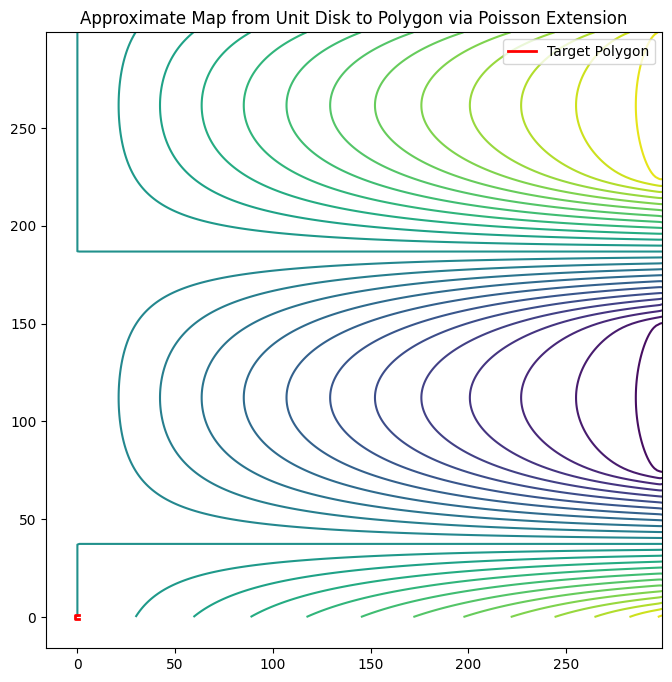

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def polygon_boundary_map(theta, vertices):
    """
    Map angles theta ∈ [0, 2π] on the unit circle to the polygon defined by vertices.
    """
    n = len(vertices)
    theta_k = np.linspace(0, 2 * np.pi, n + 1)
    vertices = np.append(vertices, vertices[0])  # Close the polygon
    # Linear interpolation separately for real and imaginary parts
    real_interp = interp1d(theta_k, np.real(vertices), kind='linear', fill_value='extrapolate')
    imag_interp = interp1d(theta_k, np.imag(vertices), kind='linear', fill_value='extrapolate')
    return real_interp(theta) + 1j * imag_interp(theta)

def poisson_integral(r, theta, boundary_func, N=512):
    """
    Approximate harmonic extension of f via Poisson integral from unit circle to interior.
    """
    phi = np.linspace(0, 2 * np.pi, N, endpoint=False)
    dphi = 2 * np.pi / N
    f_boundary = boundary_func(phi)
    u = np.zeros_like(r, dtype=np.complex128)

    for i in range(len(r)):
        num = np.sum(f_boundary * (1 - r[i] ** 2) / (1 - 2 * r[i] * np.cos(theta[i] - phi) + r[i] ** 2) * dphi)
        u[i] = num / (2 * np.pi)
    
    return u

# ---- Define your polygon ----
z_vertices = np.array([1 + 1j, -1 + 1j, -1 - 1j, 1 - 1j])  # Square as example
z0 = 0 + 0j  # f(0) will be approximately this

# ---- Grid in unit disk ----
res = 300
r_vals = np.linspace(0, 0.99, res)
theta_vals = np.linspace(0, 2 * np.pi, res)
R, T = np.meshgrid(r_vals, theta_vals)
Z = R * np.exp(1j * T)
z_flat = Z.flatten()

# ---- Apply Poisson extension ----
f_boundary = lambda theta: polygon_boundary_map(theta, z_vertices)
f_z = poisson_integral(np.abs(z_flat), np.angle(z_flat), f_boundary)
F = f_z.reshape(res, res)

# ---- Plot ----
plt.figure(figsize=(8, 8))
plt.contour(np.real(F), np.imag(F), levels=30, cmap='viridis')
plt.plot(np.real(z_vertices), np.imag(z_vertices), 'r-', linewidth=2, label='Target Polygon')
plt.gca().set_aspect('equal')
plt.title("Approximate Map from Unit Disk to Polygon via Poisson Extension")
plt.legend()
plt.show()


## Simplification itself

In [ ]:
class SimplifiedByCancelations:
    def __init__(self, image, cancelations: list[ShallowPair]=[]):
        """
        The topologica simplification of a 2-dimensional black-white image by canceling shallow pairs.
        """
        self.image = np.array(image)
        if self.image.ndim != 2:
            raise ValueError('The image should be 2-dimensional')
        self.shape = self.image.shape
        
        # Geting list of components
        g = nx.Graph()
        g.add_nodes_from(itertools.product(range(image.shape[0]), range(image.shape[1])))
        g.add_edges_from([node.source[1] for node in cancelations])
        self.components = [list(component) for component in nx.connected_components(g)]
        
        # geting the only not canceled pixels in the components
        canceled_pixels = {node.source[0] for node in cancelations}
        self.merge_targets = [set(component) - canceled_pixels for component in self.components]
        assert np.all([len(target) == 1 for target in self.merge_targets])
        self.merge_targets = [next(iter(target)) for target in self.merge_targets]

    def __len__(self):
        """
        Returns the number of components
        """
        return len(self.components)

    def get_segmentation(self, add_frame=False):
        """
        Returns the segmentation based on the cancelations

        Parameters:
        -----------
        add_frame: bool
            Add a frame as an aditional component index len(self)

        Returns:
        --------
        new_image: 2-dimensional integer np.array
        """
        if add_frame:
            segement_matrix = np.zeros([self.shape[0] + 1, self.shape[1] + 1])*len(self)
            segement_matrix[1:-1][1:-1] = self.get_segmentation(add_frame=False)
            return segement_matrix

        segement_matrix = np.zeros(self.shape)*np.nan
        for i, component in enumerate(self.components):
            rows, cols = zip(*component)
            segement_matrix[rows, cols] = i
        return segement_matrix
    
    def get_flat_representation(self):
        """
        Returns the simplified image, assuming for every component the representative merge target pixel value

        Returns:
        --------
        new_image: 2-dimensional np.array
        """
        new_image = self.image.copy()
        for component, (merge_target_x, merge_target_y) in zip(self.components, self.merge_targets):
            value = self.image[merge_target_x, merge_target_y]
            rows, cols = zip(*component)
            new_image[rows, cols] = value
        return new_image

    def get_component_connectivity_graph(self, add_frame=False):
        """
        Returns the graph, where 
        nodes are component indices
        edges exists if 2 components have a border (4-connectivity)

        Parameters:
        -----------
        add_frame: bool
            Add an aditional component index len(self), representing the frame of the image

        Returns:
        --------
        g: nx.Graph
        """
        segment_matrix = self.get_segmentation(add_frame=add_frame)
        
        edges_v = np.transpose([segment_matrix[1:, :], segment_matrix[:-1, :]], (1, 2, 0))[segment_matrix[1:, :] != segment_matrix[:-1, :]]
        edges_h = np.transpose([segment_matrix[:, 1:], segment_matrix[:, :-1]], (1, 2, 0))[segment_matrix[:, 1:] != segment_matrix[:, :-1]]
        edges = np.concatenate([edges_v, edges_h])
        edges = np.unique(np.sort(edges, axis=1), axis=0)

        g = nx.graph()
        g.add_nodes_from(np.unique(segment_matrix))
        g.add_edges_from(edges)
        return g
    
    def get_vertices(self, add_frame=False):
        """
        Returns indices of pixel, in which neighbourhood more than 2 segments.

        The neighbourhood of a pixel contains 4 pixel: this pixel itself 

        Parameters:
        -----------
        add_frame: bool
            Do we count frame as a segment
        """
        segment_matrix = self.get_segmentation(add_frame=add_frame)

        slices = np.array([segment_matrix[1:, 1:], 
                           segment_matrix[1:, :-1], 
                           segment_matrix[:-1, 1:], segment_matrix[:-1, :-1]])
        nsegments = np.apply_along_axis(lambda row: len(np.unique(row)), axis=0, arr=slices)
        vertices = np.argwhere(nsegments >= 3)
        rows, cols = zip(*vertices)
        vertex_segments = slices[:, rows, cols]
        vertex_segments = [tuple(np.unique(vertex_segment)) for vertex_segment in vertex_segments.transpose()]

        if add_frame:
            vertices -= 1
    
    def classify_components(self) -> list[str]:
        """
        Defines the types for each component. 
        There are 3 types are possible:
        - 'min' - local minima
        - 'max' - local maxima
        - 'saddle' - saddle
        """            
        try:
            self.component_types
        except NameError:
            connectivity_graph = self.get_component_connectivity_graph(add_frame=False)
            component_types = []
            for i, (i_merge_target_x, i_merge_target_y) in enumerate(self.merge_targets):
                i_value = self.image[i_merge_target_x, i_merge_target_y]
                neighbors = list(connectivity_graph.neighbors(i))
                neighbors_merge_target_x, neighbors_merge_target_y = zip(np.array(self.merge_targets)[neighbors])
                neighbors_values = self.image[neighbors_merge_target_x, neighbors_merge_target_y]
                if i_value <= neighbors_values:
                    i_type = 'min'
                elif i_value >= neighbors_values:
                    i_type = 'max'
                else:
                    i_type = 'saddle'
                component_types.append(i_type)
            self.component_types = np.array(component_types)
        return self.component_types
                


In [113]:
class DepthSimplifyer:
    def __init__(self, image):
        """
        """
        self.image = np.array(image)
        if self.image.ndim != 2:
            raise ValueError('The image should be 2-dimensional')
        
        order, dims, filtration = get_sorted_order(self.image)
        bm = get_sorted_border_matrix(self.image)
        self.depth_poset = DepthPoset.from_border_matrix(border_matrix=bm.toarray().astype('int8'), dims=dims, 
                                                         filter_values=filtration, sources=order)

    def get_simplified(self, cancelations: list[ShallowPair]=[]) -> SimplifiedByCancelations:
        """
        """
        cancelations_with_descendats = self.depth_poset.get_ancestors(cancelations, include=True).nodes
        return SimplifiedByCancelations(self.image, cancelations_with_descendats)
    
    def get_simplified_by_condition(self, condition=lambda cell: False) -> SimplifiedByCancelations:
        """
        """
        cancelations = self.depth_poset.subposet(node_condition=condition).nodes
        return self.get_simplified(cancelations)

    def get_simplified_by_fixing_height(self, height: int) -> SimplifiedByCancelations:
        """
        """
        pass

    def get_simplified_by_canceling_minimals(self, n_iters: int=1) -> SimplifiedByCancelations:
        """
        """
        dp = self.depth_poset
        minimal_nodes = []
        for i in range(n_iters):
            minimal_nodes += list(dp.iterate_minimal_nodes())
            dp = dp.subposet(node_condition=lambda node: node not in minimal_nodes)
        return self.get_simplified(cancelations=minimal_nodes)

    def get_simplified_by_canceling_short_lifes(self, life_length: float) -> SimplifiedByCancelations:
        """
        """
        condition = lambda node: node.death_value - node.birth_value < life_length
        return self.get_simplified_by_condition(condition=condition)

# Experiment

## Get Depth Posets from an Image

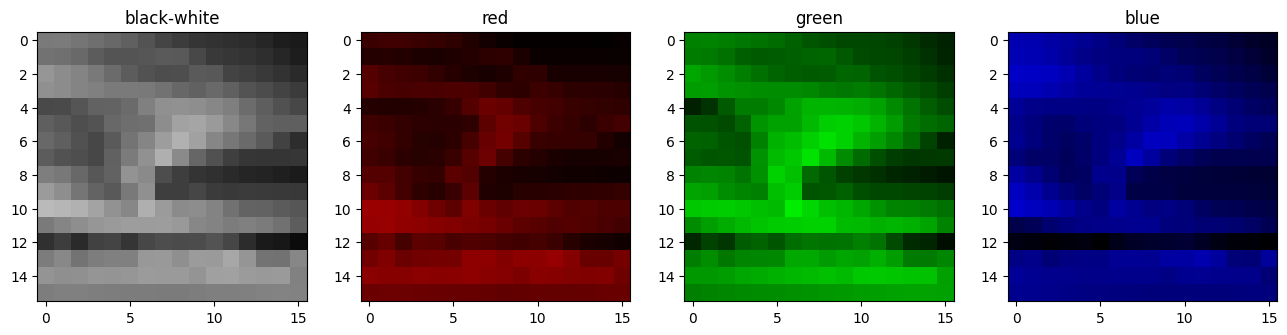

In [114]:
cases = {
    'black-white': image.mean(axis=2),
    'red': image[:, :, 0], 
    'green': image[:, :, 1], 
    'blue': image[:, :, 2], 
}

case_representations = {
    'black-white': lambda img: np.transpose([1*img, 1*img, 1*img], (1, 2, 0)), 
    'red': lambda img: np.transpose([1*img, 0*img, 0*img], (1, 2, 0)), 
    'green': lambda img: np.transpose([0*img, 1*img, 0*img], (1, 2, 0)), 
    'blue': lambda img: np.transpose([0*img, 0*img, 1*img], (1, 2, 0)), 
}

fig, axs = plt.subplots(1, len(cases), figsize=(4*len(cases), 4.5))

for i, key in enumerate(cases.keys()):
    axs[i].set_title(key)
    img = case_representations[key](cases[key])
    axs[i].imshow(img)




In [115]:
simplifyers = {key: DepthSimplifyer(img) for key, img in tqdm(cases.items(), total=len(cases))}

100%|██████████| 4/4 [00:11<00:00,  2.94s/it]


In [116]:
dps = {key: simplifyer.depth_poset for key, simplifyer in simplifyers.items()}

scores = [poset_scores.number_of_nodes, 
          poset_scores.number_of_relations, 
          poset_scores.number_of_components,
          poset_scores.height, 
          poset_scores.width,
          ]

case_scores = pd.DataFrame({key: {score.__name__: score(dp) for score in scores} for key, dp in dps.items()})
case_scores

,black-white,red,green,blue
number_of_nodes,255,255,255,255
number_of_relations,136,115,144,113
number_of_components,121,143,114,142
height,3,3,4,3
width,238,233,238,243


## Iteratively Canceling Minimal Nodes

In [117]:
max_height = case_scores.loc['height'].max()

max_height

np.int64(4)

In [118]:
df_simplifications = pd.DataFrame([{key: simplifyer.get_simplified_by_canceling_minimals(n_iters=i) for key, simplifyer in simplifyers.items()} for i in range(max_height)])

df_simplifications

,black-white,red,green,blue
0,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...
1,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...
2,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...
3,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...


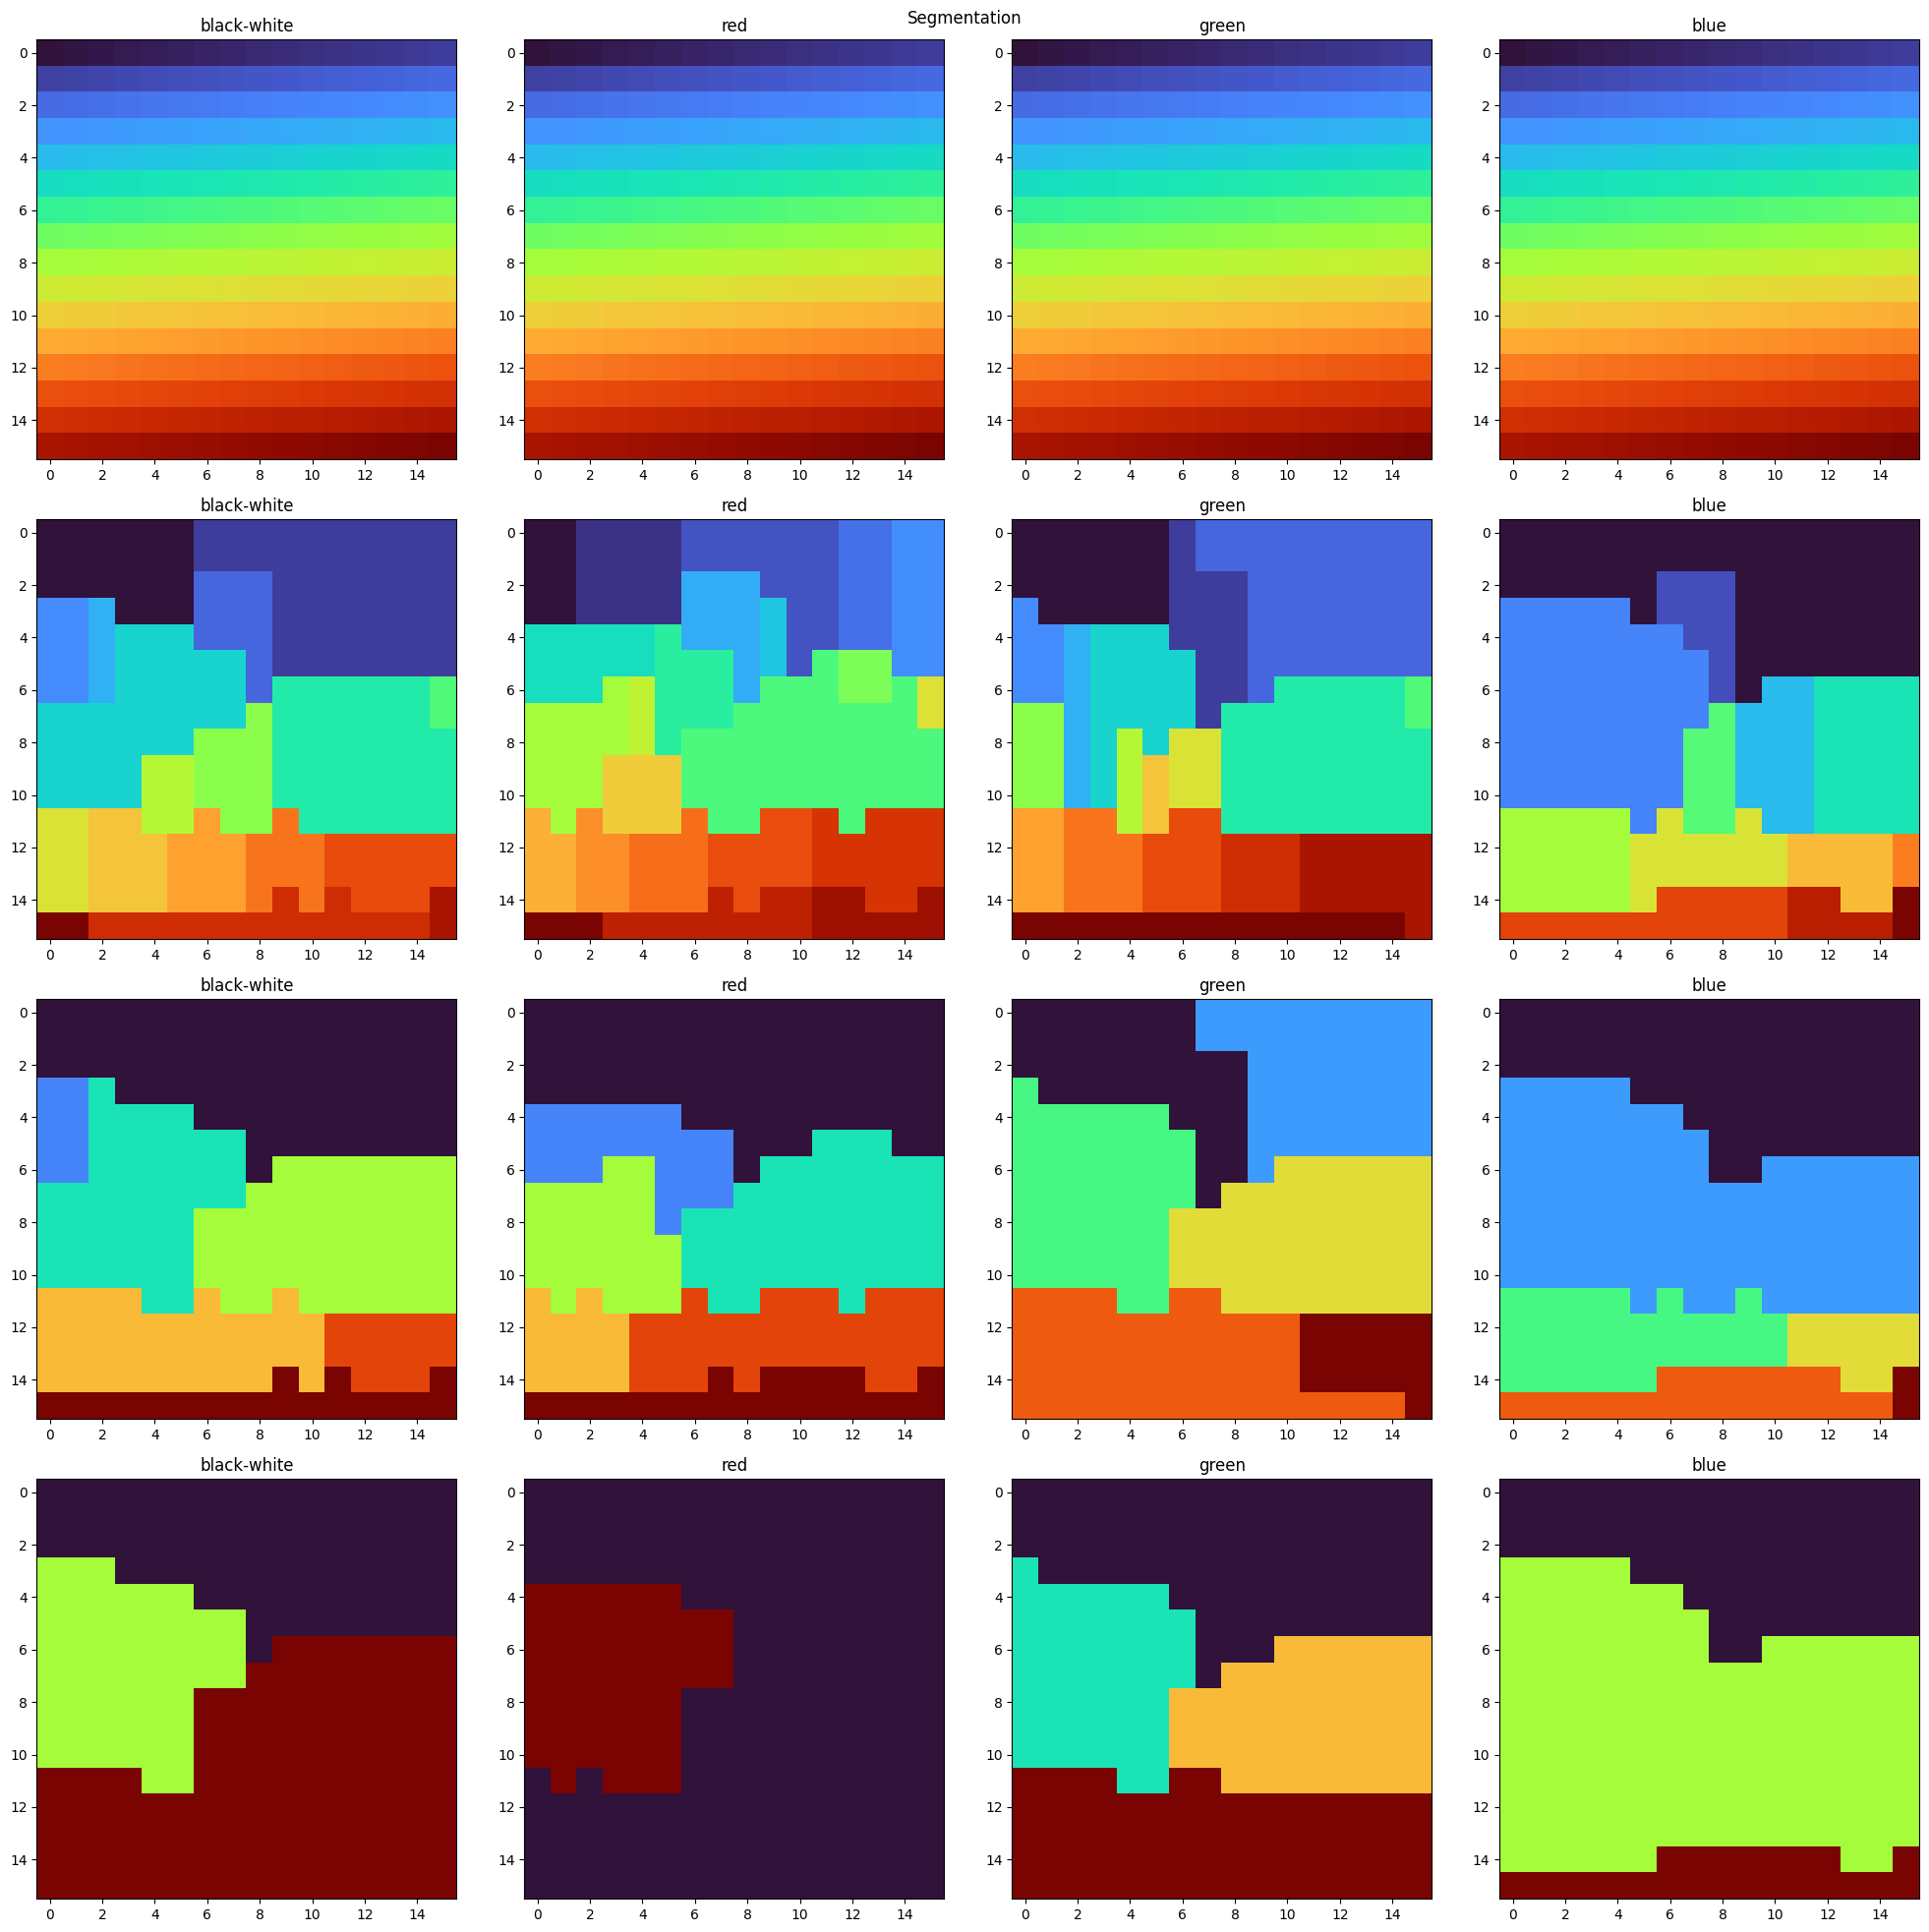

In [ ]:
fig, axs = plt.subplots(df_simplifications.shape[0], df_simplifications.shape[1], squeeze=True)
fig.set_figheight(5*df_simplifications.shape[0])
fig.set_figwidth(5*df_simplifications.shape[1])

fig.suptitle('Segmentation')
for i_row, (i_col, key) in itertools.product(range(len(df_simplifications)), enumerate(df_simplifications.columns)):
    axs[i_row, i_col].set_title(key)
    img = df_simplifications.iloc[i_row, i_col].get_segmentation()
    
    axs[i_row, i_col].imshow(img, cmap='turbo')

plt.tight_layout()
plt.show()

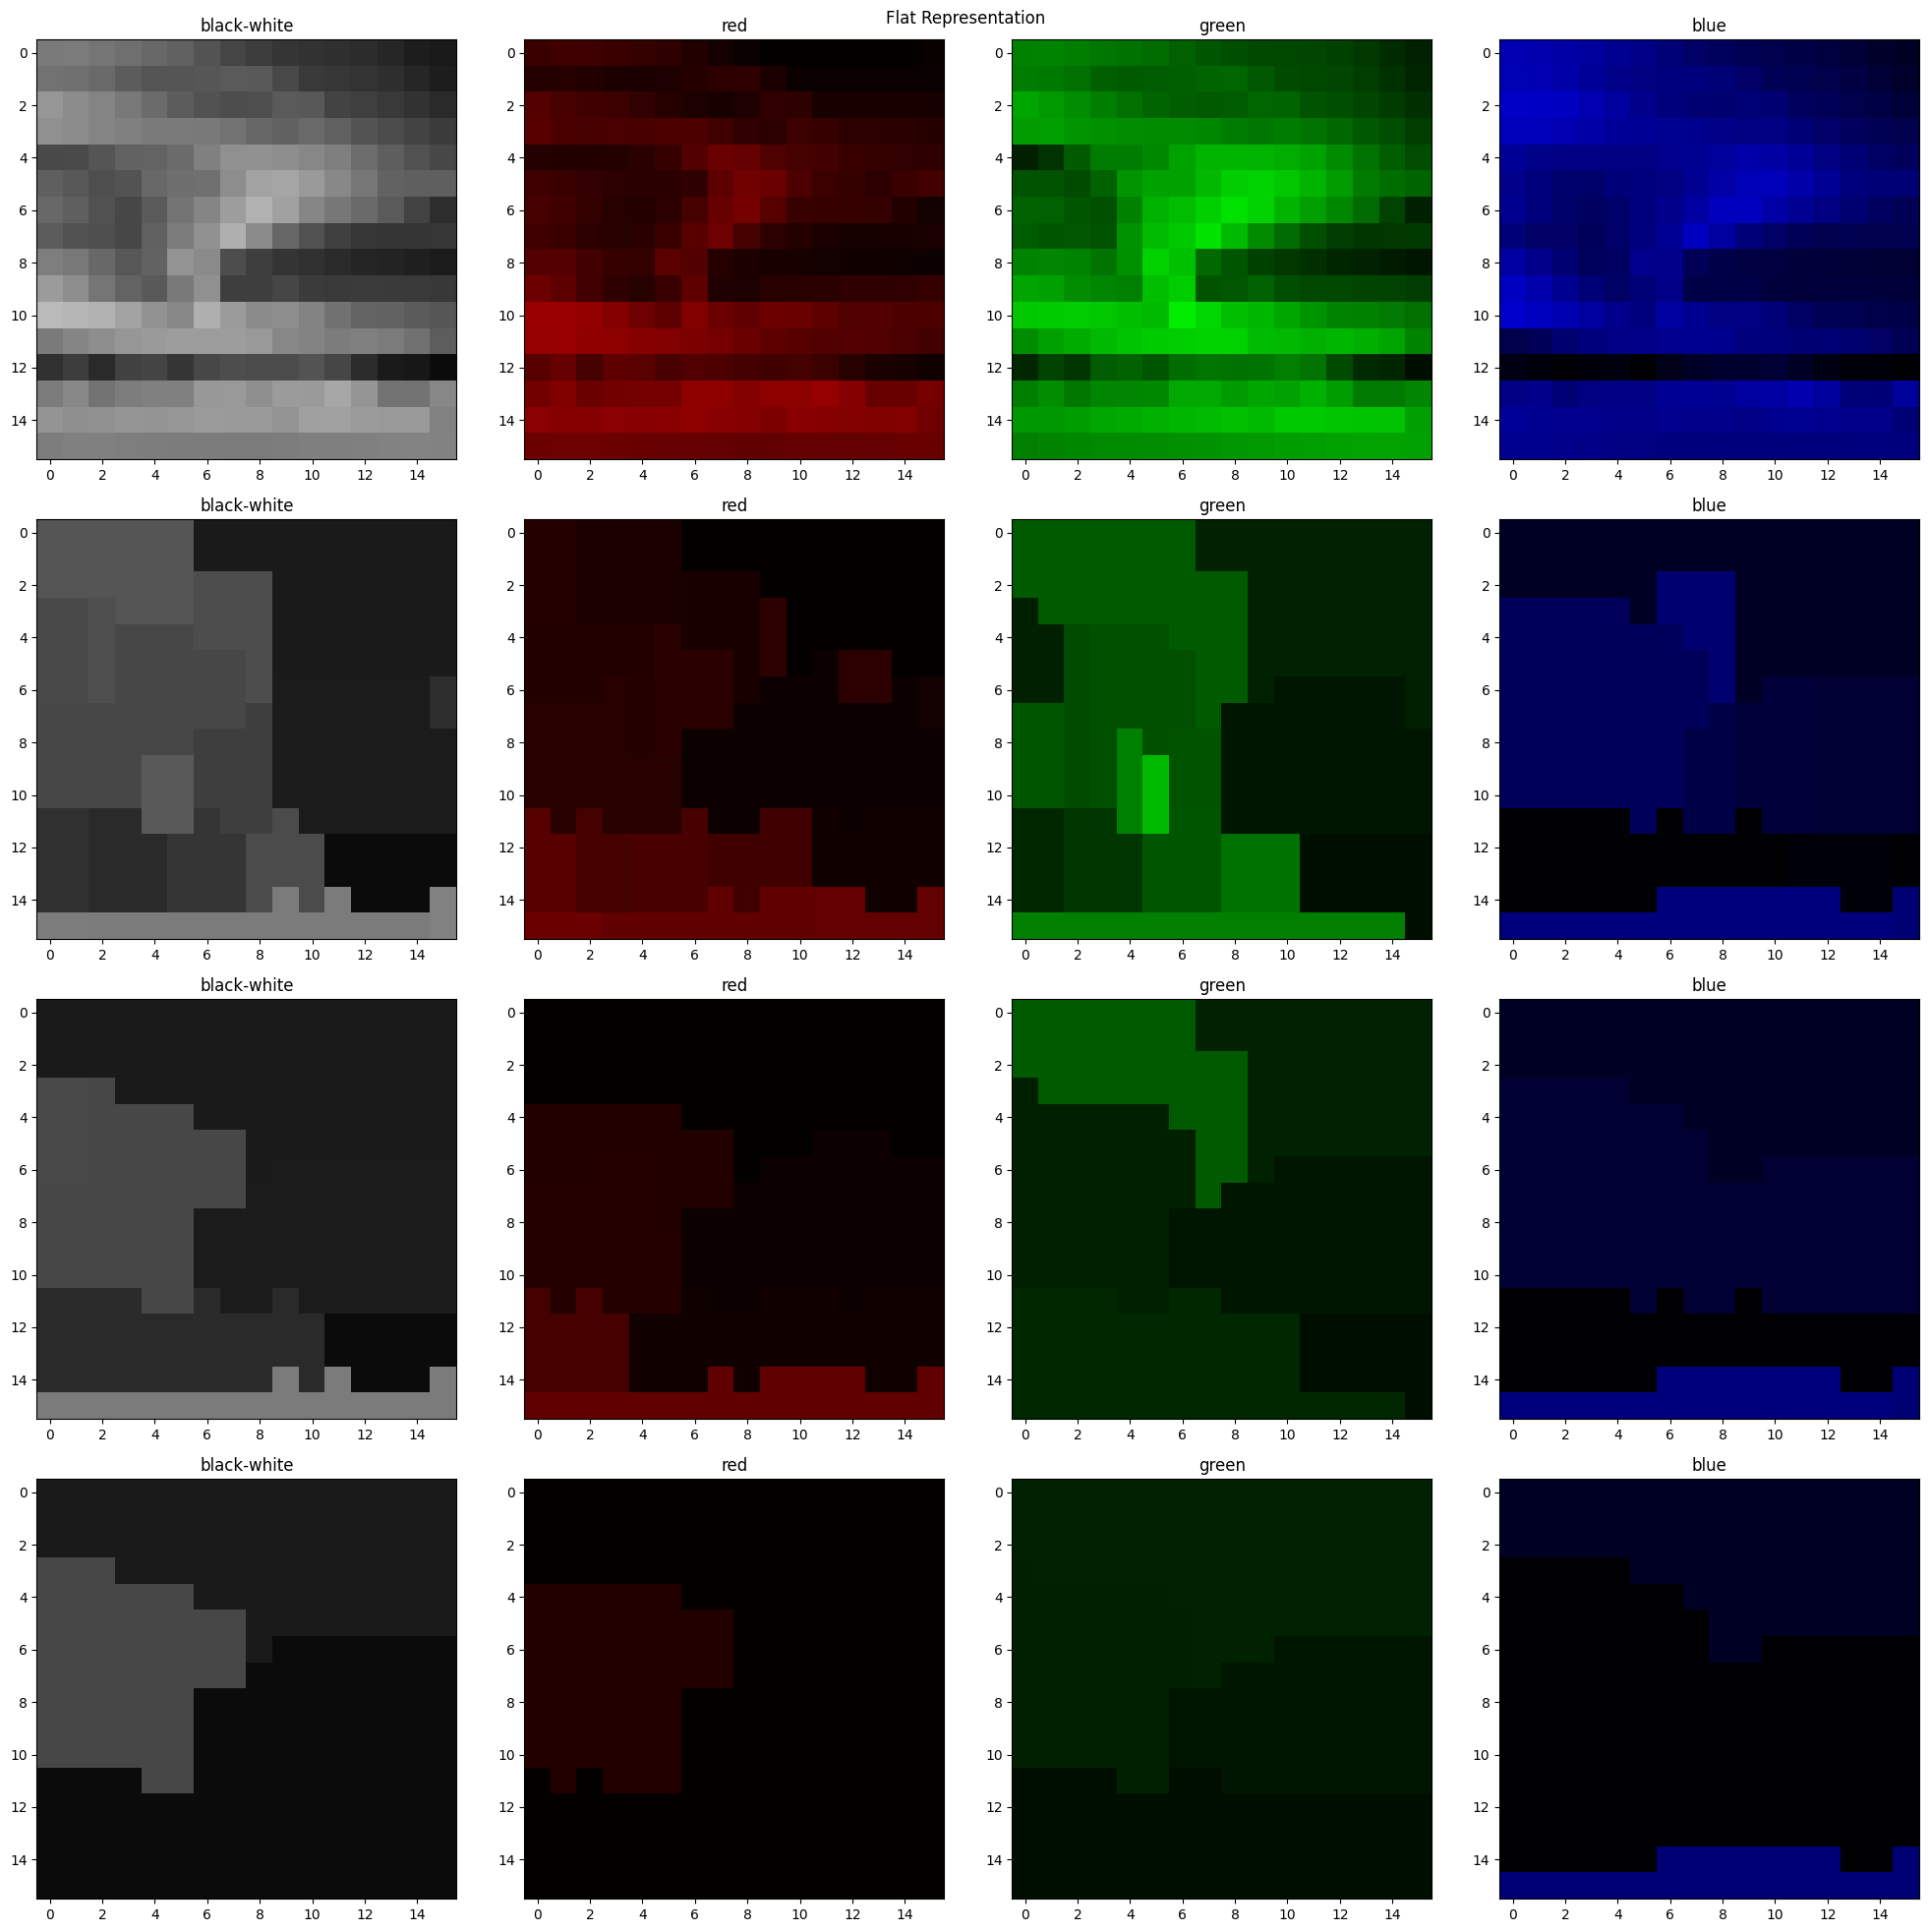

In [124]:
fig, axs = plt.subplots(df_simplifications.shape[0], df_simplifications.shape[1], squeeze=True)
fig.set_figheight(5*df_simplifications.shape[0])
fig.set_figwidth(5*df_simplifications.shape[1])

fig.suptitle('Flat Representation')
for i_row, (i_col, key) in itertools.product(range(len(df_simplifications)), enumerate(df_simplifications.columns)):
    axs[i_row, i_col].set_title(key)
    img = df_simplifications.iloc[i_row, i_col].get_flat_representation()
    img = case_representations[key](img)
    axs[i_row, i_col].imshow(img, cmap='turbo')

plt.tight_layout()
plt.show()

# Reduction algorithms for sparse border matrices